In [2]:
!pip install PyYaml

     |████████████████████████████████| 269 kB 156 kB/s eta 0:00:01
  Created wheel for PyYaml: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44619 sha256=6b79cd8ceba65024294d2129ebc0fa3f0bfab8e0f414c98211046f41af8eaf7d
  Stored in directory: /home/jovyan/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYaml


In [30]:
!pip install sklearn

     |████████████████████████████████| 7.1 MB 161 kB/s eta 0:00:01    |▍                               | 81 kB 205 kB/s eta 0:00:34     |█                               | 235 kB 177 kB/s eta 0:00:39     |█████████                       | 2.0 MB 1.4 MB/s eta 0:00:04     |█████████▏                      | 2.0 MB 1.4 MB/s eta 0:00:04     |████████████                    | 2.6 MB 1.4 MB/s eta 0:00:04     |████████████▉                   | 2.8 MB 1.4 MB/s eta 0:00:03     |███████████████████             | 4.2 MB 4.4 MB/s eta 0:00:01     |█████████████████████▏          | 4.7 MB 393 kB/s eta 0:00:07     |██████████████████████████▎     | 5.8 MB 789 kB/s eta 0:00:02     |███████████████████████████▎    | 6.0 MB 789 kB/s eta 0:00:02     |██████████████████████████████  | 6.6 MB 161 kB/s eta 0:00:03
     |████████████████████████████████| 294 kB 474 kB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=e47bf3145c5e5925f44cb6735e864ecf773f778b3

In [3]:
import os
import sys
import yaml
import numpy as np
import pandas as pd
sys.path.append('/home/jovyan/work/obstacle-detection')
import pcl
import pcl.pcl_visualization
import pythreejs
import pyntcloud
import matplotlib.pyplot as plt
from importlib import reload  

from pipeline import pcl_pipeline
from pipeline import pcl_utils

In [4]:
with open('../config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [5]:
PATH_TO_DATASET = '/home/jovyan/work/dataset_sampling/rangenet_sampling/dataset/sequences/00/'
VELODYNE        = 'velodyne/'
LABELS          = 'labels/'
PREFIX_SCAN     = '000'

In [6]:
SCAN_NUM = '055'
scan = np.fromfile(PATH_TO_DATASET + VELODYNE +  PREFIX_SCAN + SCAN_NUM + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:, :3]

label = np.fromfile(PATH_TO_DATASET + LABELS + PREFIX_SCAN + SCAN_NUM + '.label', dtype=np.uint32)
label = label.reshape((-1))

In [8]:
# visualize point cloud
%matplotlib inline
test_cloud = pyntcloud.PyntCloud(pd.DataFrame(scan[:,:3], columns=['x','y','z']))
test_cloud.plot(backend='pythreejs', use_as_color='seg_id')

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.10233774781227112, 79.79987967014313, 3.26…

In [8]:
# Obstacles id -> name mapping
obstacle_lst = config['obstacles']
obstacle_lst

{10: 'car',
 11: 'bicycle',
 13: 'bus',
 15: 'motorcycle',
 16: 'on-rails',
 18: 'truck',
 20: 'other-vehicle',
 30: 'person',
 31: 'bicyclist',
 32: 'motorcyclist',
 252: 'moving-car',
 253: 'moving-bicyclist',
 254: 'moving-person',
 255: 'moving-motorcyclist',
 256: 'moving-on-rails',
 257: 'moving-bus',
 258: 'moving-truck',
 259: 'moving-other-vehicle'}

In [209]:
%time pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), columns=['x', 'y', 'z', 'seg_id'])

CPU times: user 13.7 ms, sys: 2.12 ms, total: 15.8 ms
Wall time: 15.9 ms


In [210]:
%%time
pcloud = common.roi_filter(pcloud,  min_x=params['roi_x_min'], max_x=params['roi_x_max'], 
                                                min_y=params['roi_y_min'], max_y=params['roi_y_max'],
                                                min_z=params['roi_z_min'], max_z=params['roi_z_max'], 
                                                verbose=False)

CPU times: user 53.6 ms, sys: 3.68 ms, total: 57.3 ms
Wall time: 57.3 ms


In [211]:
%time pcloud = common.obstacle_filter(pcloud, obstacle_lst, proc_labels=True, verbose=False)

CPU times: user 217 ms, sys: 2.92 ms, total: 220 ms
Wall time: 229 ms


In [10]:
from datetime import datetime
import time
from importlib import reload  
from pipeline import common

pcl_utils = reload(pcl_utils)

def pipeline_optimized_pcl(scan, label, obstacle_lst, verbose=False, exec_time=False, **params):
    # get segment id
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                          columns=['x', 'y', 'z', 'seg_id'])
    
    pcloud = common.roi_filter(pcloud,  min_x=params['roi_x_min'], max_x=params['roi_x_max'], 
                                                min_y=params['roi_y_min'], max_y=params['roi_y_max'],
                                                min_z=params['roi_z_min'], max_z=params['roi_z_max'], 
                                                verbose=False)
    
    pcloud = common.obstacle_filter(pcloud, obstacle_lst, proc_labels=True, verbose=False)
    pcloud = pcloud.drop(['seg_id'], axis=1)
    pcloud = pcloud.drop(['camera'], axis=1)
    obstacle_time = datetime.now() - start_time
    
    if (len(pcloud.index) > 0):
        start_time = datetime.now()
        pcloud_pcl = pcl.PointCloud()
        pcloud_pcl.from_array(pcloud.to_numpy(dtype=np.float32))
        convert_time = datetime.now() - start_time

        # get voxel grid
        start_time = datetime.now()
        voxelgrid_id = pcl_utils.voxel_filter(pcloud_pcl, [params['x_voxels'],
                                                              params['y_voxels'],
                                                              params['z_voxels']])
        #voxelgrid_id = pcloud_pcl  
        voxel_time = datetime.now() - start_time

        # ROI filter
        start_time = datetime.now()
        pcloud_roi = pcl_utils.roi_filter(voxelgrid_id, [params['roi_x_min'], params['roi_x_max']], 
                                        [params['roi_y_min'], params['roi_y_max']], 
                                        [params['roi_z_min'], params['roi_z_max']],)
        roi_time = datetime.now() - start_time


        # get cluster
        start_time = datetime.now()
        cloud_obsts = pcloud_roi.extract([], negative = True)
        cluster_indices = pcl_utils.clustering(cloud_obsts, params['tol_distance'], params['min_cluster_size'], 150000)        
        clustering_time = datetime.now() - start_time

        # get bboxes
        start_time = datetime.now()
        box_min_max_list, box_coord_list = pcl_utils.get_cluster_box_list(
                                                    cluster_indices, cloud_obsts, 
                                                    radius_search=params['radius_search'], 
                                                    min_neighbors_in_radius=params['min_neighbors_in_radius'])
        bbox_time = datetime.now() - start_time
    else:
        box_min_max_list, box_coord_list = np.empty((0, 0)), np.empty((0, 0))
        roi_time, obstacle_time, voxel_time, clustering_time, bbox_time = 0, 0, 0, 0, 0
    
    if verbose:
        print('Execution time:')
        print('\n - ROI filtering: {:.5f} s'.format(roi_time.total_seconds()))
        print('\n - Filtering obstacles: {:.5f} s'.format(obstacle_time.total_seconds()))
        print('\n - Voxel grid: {:.5f} s'.format(voxel_time.total_seconds()))
        print('\n - Clustering: {:.5f} s'.format(clustering_time.total_seconds()))
        print('\n - Min-max cluster points: {:.5f} s \n'.format(bbox_time.total_seconds()))
        
    if exec_time:
        return box_min_max_list, box_coord_list, {'roi_time': roi_time.total_seconds(),
                                        'filter_obstacle_time': obstacle_time.total_seconds(),
                                        'voxel_grid_time': voxel_time.total_seconds(),
                                        'clustering_time': clustering_time.total_seconds(),
                                        'outlier_filter_bbox_time': bbox_time.total_seconds(),
                                        'convert_time' : convert_time.total_seconds()}
    else:
        return box_min_max_list, box_coord_list

In [12]:
# from pipeline import pcl_pipeline
pcl_pipeline = reload(pcl_pipeline)

params = {'x_voxels'     : 0.3, 'y_voxels': 0.3, 'z_voxels': 0.3, 
          'roi_x_min'    : -30,   'roi_x_max'              : 30,
          'roi_y_min'    : -6, 'roi_y_max'                : 8,
          'roi_z_min'    : -3,  'roi_z_max'                : 3, 
          'tol_distance' : 0.7, 'min_cluster_size'         : 30,
          'radius_search': 0.8,   'min_neighbors_in_radius': 2}
%time box_min_max_list, box_coord_list, time = pipeline_optimized_pcl(scan, label, obstacle_lst, verbose=True, exec_time=True, **params)

Execution time:

 - ROI filtering: 0.00076 s

 - Filtering obstacles: 0.27085 s

 - Voxel grid: 0.00487 s

 - Clustering: 0.04052 s

 - Min-max cluster points: 0.05584 s 

CPU times: user 320 ms, sys: 54.1 ms, total: 374 ms
Wall time: 376 ms


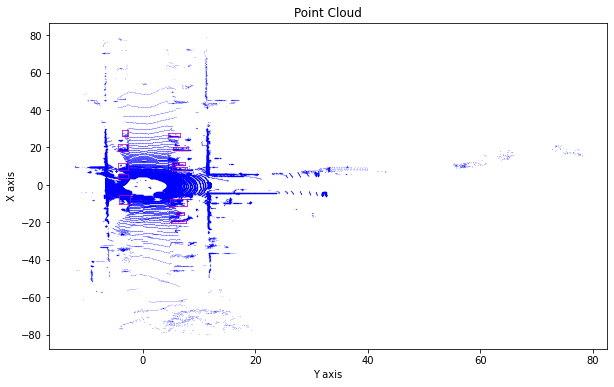

In [208]:
from scripts import draw

%matplotlib inline
f = plt.figure(figsize=(10, 6))
axes = [1,0]
# ax = f.add_subplot(111, projection='3d') 
ax = f.add_subplot(111) 
draw.draw_point_cloud(scan, ax, 'Point Cloud',axes=axes, 
                      axes_str = ['X', 'Y', 'Z'], )
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

In [204]:
params = {'x_voxels'     : 0.3, 'y_voxels': 0.3, 'z_voxels': 0.3, 
          'roi_x_min'    : -30,   'roi_x_max'              : 30,
          'roi_y_min'    : -6, 'roi_y_max'                : 8,
          'roi_z_min'    : -3,  'roi_z_max'                : 3, 
          'tol_distance' : 0.7, 'min_cluster_size'         : 30,
          'radius_search': 0.8,   'min_neighbors_in_radius': 2}

In [31]:
from scripts import test
import sklearn
test = reload(test)
range_params = params = { 'x_voxels'     : [0.3, 0.5, 0.8], 'y_voxels': [0.3, 0.5, 0.8], 'z_voxels': [0.3, 0.5, 0.8], 
                          'roi_x_min'    : [0],   'roi_x_max'                : [45],
                          'roi_y_min'    : [-15], 'roi_y_max'                : [15],
                          'roi_z_min'    : [-2],  'roi_z_max'                : [1], 
                          'tol_distance' : [0.5, 0.7, 0.9], 'min_cluster_size' : [20, 30, 40],
                          'radius_search': [0.5, 0.8, 1],   'min_neighbors_in_radius': [2, 4, 6]}
time_exec_lst = test.grid_search_optimization(scan, label, obstacle_lst, pipeline_optimized_pcl, range_params)

Total time 0.31793999999999994 ms. Created 10 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000418,
   "filter_obstacle_time": 0.255515,
   "voxel_grid_time": 0.002781,
   "clustering_time": 0.023985,
   "outlier_filter_bbox_time": 0.034992,
   "convert_time": 0.000249
}
****************************************

Total time 0.39991499999999996 ms. Created 10 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_

Total time 0.41969799999999996 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000287,
   "filter_obstacle_time": 0.381914,
   "voxel_grid_time": 0.003105,
   "clustering_time": 0.023171,
   "outlier_filter_bbox_time": 0.010884,
   "convert_time": 0.000337
}
****************************************

Total time 0.393123 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3


Total time 0.500288 ms. Created 10 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000362,
   "filter_obstacle_time": 0.40485,
   "voxel_grid_time": 0.002976,
   "clustering_time": 0.037623,
   "outlier_filter_bbox_time": 0.054213,
   "convert_time": 0.000264
}
****************************************

Total time 0.301978 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi

Total time 0.463112 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000259,
   "filter_obstacle_time": 0.342187,
   "voxel_grid_time": 0.002695,
   "clustering_time": 0.037039,
   "outlier_filter_bbox_time": 0.08071,
   "convert_time": 0.000222
}
****************************************

Total time 0.4382 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_ti

Total time 0.3359579999999999 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000362,
   "filter_obstacle_time": 0.285238,
   "voxel_grid_time": 0.002644,
   "clustering_time": 0.01713,
   "outlier_filter_bbox_time": 0.029505,
   "convert_time": 0.001079
}
****************************************

Total time 0.307108 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}


Total time 0.272735 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000212,
   "filter_obstacle_time": 0.246355,
   "voxel_grid_time": 0.00261,
   "clustering_time": 0.009095,
   "outlier_filter_bbox_time": 0.01421,
   "convert_time": 0.000253
}
****************************************

Total time 0.271651 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_t

Total time 0.7652730000000001 ms. Created 10 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000555,
   "filter_obstacle_time": 0.633491,
   "voxel_grid_time": 0.003546,
   "clustering_time": 0.044768,
   "outlier_filter_bbox_time": 0.082562,
   "convert_time": 0.000351
}
****************************************

Total time 0.7016580000000001 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_vox

Total time 0.5135330000000001 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000183,
   "filter_obstacle_time": 0.499291,
   "voxel_grid_time": 0.002932,
   "clustering_time": 0.010823,
   "outlier_filter_bbox_time": 4e-05,
   "convert_time": 0.000264
}
****************************************

Total time 0.534534 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{


Total time 0.66707 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.00033,
   "filter_obstacle_time": 0.595967,
   "voxel_grid_time": 0.002902,
   "clustering_time": 0.022416,
   "outlier_filter_bbox_time": 0.045211,
   "convert_time": 0.000244
}
****************************************

Total time 0.448954 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_t

Total time 0.30893200000000004 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000331,
   "filter_obstacle_time": 0.263681,
   "voxel_grid_time": 0.002821,
   "clustering_time": 0.01635,
   "outlier_filter_bbox_time": 0.025525,
   "convert_time": 0.000224
}
****************************************

Total time 0.279854 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}

Total time 0.33457 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000231,
   "filter_obstacle_time": 0.299568,
   "voxel_grid_time": 0.002681,
   "clustering_time": 0.013008,
   "outlier_filter_bbox_time": 0.018853,
   "convert_time": 0.000229
}
****************************************

Total time 0.303446 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_

Total time 0.302671 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000247,
   "filter_obstacle_time": 0.266109,
   "voxel_grid_time": 0.002572,
   "clustering_time": 0.013162,
   "outlier_filter_bbox_time": 0.02027,
   "convert_time": 0.000311
}
****************************************

Total time 0.280614 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_

Total time 0.31287699999999996 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000284,
   "filter_obstacle_time": 0.269426,
   "voxel_grid_time": 0.002665,
   "clustering_time": 0.016711,
   "outlier_filter_bbox_time": 0.02356,
   "convert_time": 0.000231
}
****************************************

Total time 0.30036199999999996 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels"

Total time 0.281042 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000184,
   "filter_obstacle_time": 0.255662,
   "voxel_grid_time": 0.002662,
   "clustering_time": 0.009092,
   "outlier_filter_bbox_time": 0.013116,
   "convert_time": 0.000326
}
****************************************

Total time 0.28039400000000003 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{


Total time 0.30496599999999996 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000283,
   "filter_obstacle_time": 0.260509,
   "voxel_grid_time": 0.002732,
   "clustering_time": 0.013605,
   "outlier_filter_bbox_time": 0.027616,
   "convert_time": 0.000221
}
****************************************

Total time 0.305726 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{


Total time 0.29097199999999995 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000297,
   "filter_obstacle_time": 0.246495,
   "voxel_grid_time": 0.002692,
   "clustering_time": 0.011849,
   "outlier_filter_bbox_time": 0.029402,
   "convert_time": 0.000237
}
****************************************

Total time 0.303864 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{


Total time 0.281733 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000189,
   "filter_obstacle_time": 0.252971,
   "voxel_grid_time": 0.002516,
   "clustering_time": 0.009954,
   "outlier_filter_bbox_time": 0.015791,
   "convert_time": 0.000312
}
****************************************

Total time 0.314774 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_tim

Total time 0.30494299999999996 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000171,
   "filter_obstacle_time": 0.280533,
   "voxel_grid_time": 0.002775,
   "clustering_time": 0.009277,
   "outlier_filter_bbox_time": 0.011952,
   "convert_time": 0.000235
}
****************************************

Total time 0.302659 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{


Total time 0.3148990000000001 ms. Created 10 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000522,
   "filter_obstacle_time": 0.262626,
   "voxel_grid_time": 0.003155,
   "clustering_time": 0.020635,
   "outlier_filter_bbox_time": 0.027731,
   "convert_time": 0.00023
}
****************************************

Total time 0.362751 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}

Total time 0.367081 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000187,
   "filter_obstacle_time": 0.354573,
   "voxel_grid_time": 0.003552,
   "clustering_time": 0.008443,
   "outlier_filter_bbox_time": 4e-05,
   "convert_time": 0.000286
}
****************************************

Total time 0.37636100000000006 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{

Total time 0.338568 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000322,
   "filter_obstacle_time": 0.292262,
   "voxel_grid_time": 0.002641,
   "clustering_time": 0.01564,
   "outlier_filter_bbox_time": 0.027406,
   "convert_time": 0.000297
}
****************************************

Total time 0.340262 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_

Total time 0.25729900000000006 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000177,
   "filter_obstacle_time": 0.224444,
   "voxel_grid_time": 0.002608,
   "clustering_time": 0.008625,
   "outlier_filter_bbox_time": 0.021226,
   "convert_time": 0.000219
}
****************************************

Total time 0.271357 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5


Total time 0.30746100000000004 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000282,
   "filter_obstacle_time": 0.264712,
   "voxel_grid_time": 0.002686,
   "clustering_time": 0.015726,
   "outlier_filter_bbox_time": 0.023748,
   "convert_time": 0.000307
}
****************************************

Total time 0.29042499999999993 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_vo

Total time 0.253153 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000142,
   "filter_obstacle_time": 0.23503,
   "voxel_grid_time": 0.002575,
   "clustering_time": 0.00679,
   "outlier_filter_bbox_time": 0.008382,
   "convert_time": 0.000234
}
****************************************

Total time 0.24207599999999999 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}


Total time 0.399194 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000338,
   "filter_obstacle_time": 0.3499,
   "voxel_grid_time": 0.002728,
   "clustering_time": 0.019484,
   "outlier_filter_bbox_time": 0.026492,
   "convert_time": 0.000252
}
****************************************

Total time 0.31262300000000004 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}


Total time 0.26665 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.00012,
   "filter_obstacle_time": 0.258637,
   "voxel_grid_time": 0.002525,
   "clustering_time": 0.005107,
   "outlier_filter_bbox_time": 2.5e-05,
   "convert_time": 0.000236
}
****************************************

Total time 0.31210499999999997 ms. Created 10 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}


Total time 0.26922399999999996 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000233,
   "filter_obstacle_time": 0.237305,
   "voxel_grid_time": 0.002616,
   "clustering_time": 0.011155,
   "outlier_filter_bbox_time": 0.017599,
   "convert_time": 0.000316
}
****************************************

Total time 0.273843 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8


Total time 0.33718100000000006 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000429,
   "filter_obstacle_time": 0.255317,
   "voxel_grid_time": 0.00331,
   "clustering_time": 0.030501,
   "outlier_filter_bbox_time": 0.047264,
   "convert_time": 0.00036
}
****************************************

Total time 0.34734999999999994 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxe

Total time 0.285416 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000185,
   "filter_obstacle_time": 0.25143,
   "voxel_grid_time": 0.002516,
   "clustering_time": 0.009789,
   "outlier_filter_bbox_time": 0.021193,
   "convert_time": 0.000303
}
****************************************

Total time 0.261479 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_

Total time 0.300907 ms. Created 10 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000379,
   "filter_obstacle_time": 0.245693,
   "voxel_grid_time": 0.002819,
   "clustering_time": 0.019906,
   "outlier_filter_bbox_time": 0.031745,
   "convert_time": 0.000365
}
****************************************

Total time 0.30276 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_tim

Total time 0.268996 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.00021,
   "filter_obstacle_time": 0.243117,
   "voxel_grid_time": 0.002597,
   "clustering_time": 0.011925,
   "outlier_filter_bbox_time": 0.010926,
   "convert_time": 0.000221
}
****************************************

Total time 0.252311 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time

Total time 0.30147399999999996 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000385,
   "filter_obstacle_time": 0.247602,
   "voxel_grid_time": 0.002908,
   "clustering_time": 0.016547,
   "outlier_filter_bbox_time": 0.033661,
   "convert_time": 0.000371
}
****************************************

Total time 0.288797 ms. Created 10 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{

Total time 0.295766 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000237,
   "filter_obstacle_time": 0.267585,
   "voxel_grid_time": 0.0026,
   "clustering_time": 0.008893,
   "outlier_filter_bbox_time": 0.01613,
   "convert_time": 0.000321
}
****************************************

Total time 0.25404099999999996 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   

Total time 0.357573 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000383,
   "filter_obstacle_time": 0.298967,
   "voxel_grid_time": 0.002702,
   "clustering_time": 0.021111,
   "outlier_filter_bbox_time": 0.034153,
   "convert_time": 0.000257
}
****************************************

Total time 0.33145500000000006 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{


Total time 0.313724 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000154,
   "filter_obstacle_time": 0.285138,
   "voxel_grid_time": 0.002626,
   "clustering_time": 0.009171,
   "outlier_filter_bbox_time": 0.016314,
   "convert_time": 0.000321
}
****************************************

Total time 0.431647 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_tim

Total time 0.5947450000000001 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000277,
   "filter_obstacle_time": 0.528386,
   "voxel_grid_time": 0.004468,
   "clustering_time": 0.022468,
   "outlier_filter_bbox_time": 0.038849,
   "convert_time": 0.000297
}
****************************************

Total time 0.601685 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}

Total time 0.309478 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.00038,
   "filter_obstacle_time": 0.250669,
   "voxel_grid_time": 0.003219,
   "clustering_time": 0.028203,
   "outlier_filter_bbox_time": 0.026575,
   "convert_time": 0.000432
}
****************************************

Total time 0.29044099999999995 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}

Total time 0.302792 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000229,
   "filter_obstacle_time": 0.258684,
   "voxel_grid_time": 0.00283,
   "clustering_time": 0.015963,
   "outlier_filter_bbox_time": 0.024729,
   "convert_time": 0.000357
}
****************************************

Total time 0.301517 ms. Created 10 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi

Total time 0.273863 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000285,
   "filter_obstacle_time": 0.234578,
   "voxel_grid_time": 0.002883,
   "clustering_time": 0.015079,
   "outlier_filter_bbox_time": 0.020748,
   "convert_time": 0.00029
}
****************************************

Total time 0.26832 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_t

Total time 0.322605 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000454,
   "filter_obstacle_time": 0.267076,
   "voxel_grid_time": 0.002683,
   "clustering_time": 0.022423,
   "outlier_filter_bbox_time": 0.029657,
   "convert_time": 0.000312
}
****************************************

Total time 0.31287 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_

Total time 0.270429 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000295,
   "filter_obstacle_time": 0.239111,
   "voxel_grid_time": 0.003255,
   "clustering_time": 0.011363,
   "outlier_filter_bbox_time": 0.016112,
   "convert_time": 0.000293
}
****************************************

Total time 0.29166800000000004 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3


Total time 0.278304 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000313,
   "filter_obstacle_time": 0.240825,
   "voxel_grid_time": 0.00346,
   "clustering_time": 0.012944,
   "outlier_filter_bbox_time": 0.020471,
   "convert_time": 0.000291
}
****************************************

Total time 0.26565399999999995 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}

Total time 0.275848 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000312,
   "filter_obstacle_time": 0.243726,
   "voxel_grid_time": 0.003049,
   "clustering_time": 0.013601,
   "outlier_filter_bbox_time": 0.014812,
   "convert_time": 0.000348
}
****************************************

Total time 0.28685000000000005 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5


Total time 0.28078200000000003 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000198,
   "filter_obstacle_time": 0.244942,
   "voxel_grid_time": 0.002676,
   "clustering_time": 0.013013,
   "outlier_filter_bbox_time": 0.019695,
   "convert_time": 0.000258
}
****************************************

Total time 0.29763999999999996 ms. Created 10 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_v

Total time 0.267181 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000232,
   "filter_obstacle_time": 0.241056,
   "voxel_grid_time": 0.003305,
   "clustering_time": 0.00883,
   "outlier_filter_bbox_time": 0.013482,
   "convert_time": 0.000276
}
****************************************

Total time 0.259516 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_

Total time 0.311143 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000497,
   "filter_obstacle_time": 0.238352,
   "voxel_grid_time": 0.003208,
   "clustering_time": 0.033701,
   "outlier_filter_bbox_time": 0.035005,
   "convert_time": 0.00038
}
****************************************

Total time 0.28275300000000003 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}

Total time 0.26431499999999997 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000255,
   "filter_obstacle_time": 0.243516,
   "voxel_grid_time": 0.003172,
   "clustering_time": 0.008349,
   "outlier_filter_bbox_time": 0.008742,
   "convert_time": 0.000281
}
****************************************

Total time 0.276437 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3


Total time 0.284388 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000296,
   "filter_obstacle_time": 0.239784,
   "voxel_grid_time": 0.002834,
   "clustering_time": 0.01699,
   "outlier_filter_bbox_time": 0.024199,
   "convert_time": 0.000285
}
****************************************

Total time 0.27987799999999996 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
 

Total time 0.25834 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000212,
   "filter_obstacle_time": 0.242234,
   "voxel_grid_time": 0.002735,
   "clustering_time": 0.008403,
   "outlier_filter_bbox_time": 0.004452,
   "convert_time": 0.000304
}
****************************************

Total time 0.25294300000000003 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
 

Total time 0.30593800000000004 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000286,
   "filter_obstacle_time": 0.254511,
   "voxel_grid_time": 0.003112,
   "clustering_time": 0.023519,
   "outlier_filter_bbox_time": 0.024129,
   "convert_time": 0.000381
}
****************************************

Total time 0.30784900000000004 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels

Total time 0.25885600000000003 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000152,
   "filter_obstacle_time": 0.242591,
   "voxel_grid_time": 0.00285,
   "clustering_time": 0.007224,
   "outlier_filter_bbox_time": 0.005595,
   "convert_time": 0.000444
}
****************************************

Total time 0.2626580000000001 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels":

Total time 0.33389499999999994 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000331,
   "filter_obstacle_time": 0.271211,
   "voxel_grid_time": 0.003237,
   "clustering_time": 0.021149,
   "outlier_filter_bbox_time": 0.037666,
   "convert_time": 0.000301
}
****************************************

Total time 0.293745 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{


Total time 0.253472 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000117,
   "filter_obstacle_time": 0.236723,
   "voxel_grid_time": 0.002586,
   "clustering_time": 0.006611,
   "outlier_filter_bbox_time": 0.007198,
   "convert_time": 0.000237
}
****************************************

Total time 0.30537000000000003 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}


Total time 0.265664 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000222,
   "filter_obstacle_time": 0.234872,
   "voxel_grid_time": 0.002992,
   "clustering_time": 0.012775,
   "outlier_filter_bbox_time": 0.014485,
   "convert_time": 0.000318
}
****************************************

Total time 0.25955 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_

Total time 0.334429 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000474,
   "filter_obstacle_time": 0.268375,
   "voxel_grid_time": 0.002769,
   "clustering_time": 0.027437,
   "outlier_filter_bbox_time": 0.03514,
   "convert_time": 0.000234
}
****************************************

Total time 0.30798000000000003 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}

Total time 0.28370999999999996 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000226,
   "filter_obstacle_time": 0.261453,
   "voxel_grid_time": 0.00321,
   "clustering_time": 0.009424,
   "outlier_filter_bbox_time": 0.009006,
   "convert_time": 0.000391
}
****************************************

Total time 0.28004200000000007 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_vox

Total time 0.296267 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000408,
   "filter_obstacle_time": 0.23734,
   "voxel_grid_time": 0.002721,
   "clustering_time": 0.026097,
   "outlier_filter_bbox_time": 0.029403,
   "convert_time": 0.000298
}
****************************************

Total time 0.296854 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_

Total time 0.27578300000000006 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000222,
   "filter_obstacle_time": 0.239933,
   "voxel_grid_time": 0.002705,
   "clustering_time": 0.01698,
   "outlier_filter_bbox_time": 0.015651,
   "convert_time": 0.000292
}
****************************************

Total time 0.27389800000000003 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_vox

Total time 0.287479 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000347,
   "filter_obstacle_time": 0.241594,
   "voxel_grid_time": 0.002777,
   "clustering_time": 0.01711,
   "outlier_filter_bbox_time": 0.025339,
   "convert_time": 0.000312
}
****************************************

Total time 0.294994 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_

Total time 0.25800900000000004 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000431,
   "filter_obstacle_time": 0.24485,
   "voxel_grid_time": 0.002779,
   "clustering_time": 0.009581,
   "outlier_filter_bbox_time": 3.9e-05,
   "convert_time": 0.000329
}
****************************************

Total time 0.252637 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}


Total time 0.30848400000000004 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000415,
   "filter_obstacle_time": 0.250908,
   "voxel_grid_time": 0.003089,
   "clustering_time": 0.027281,
   "outlier_filter_bbox_time": 0.026543,
   "convert_time": 0.000248
}
****************************************

Total time 0.281342 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5


Total time 0.260675 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.00025,
   "filter_obstacle_time": 0.246065,
   "voxel_grid_time": 0.003052,
   "clustering_time": 0.008487,
   "outlier_filter_bbox_time": 0.002542,
   "convert_time": 0.000279
}
****************************************

Total time 0.293368 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_

Total time 0.291865 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000341,
   "filter_obstacle_time": 0.243592,
   "voxel_grid_time": 0.002646,
   "clustering_time": 0.020083,
   "outlier_filter_bbox_time": 0.024856,
   "convert_time": 0.000347
}
****************************************

Total time 0.279537 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi

Total time 0.2991 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000306,
   "filter_obstacle_time": 0.253558,
   "voxel_grid_time": 0.002582,
   "clustering_time": 0.017638,
   "outlier_filter_bbox_time": 0.024712,
   "convert_time": 0.000304
}
****************************************

Total time 0.27429200000000004 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}


Total time 0.28138099999999994 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000236,
   "filter_obstacle_time": 0.247919,
   "voxel_grid_time": 0.002732,
   "clustering_time": 0.012727,
   "outlier_filter_bbox_time": 0.017536,
   "convert_time": 0.000231
}
****************************************

Total time 0.27458299999999997 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels

Total time 0.277427 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000227,
   "filter_obstacle_time": 0.241915,
   "voxel_grid_time": 0.002843,
   "clustering_time": 0.013439,
   "outlier_filter_bbox_time": 0.018743,
   "convert_time": 0.00026
}
****************************************

Total time 0.29163 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time"

Total time 0.32591699999999996 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000465,
   "filter_obstacle_time": 0.275052,
   "voxel_grid_time": 0.003342,
   "clustering_time": 0.021406,
   "outlier_filter_bbox_time": 0.025039,
   "convert_time": 0.000613
}
****************************************

Total time 0.3090010000000001 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels"

Total time 0.27002500000000007 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.00026,
   "filter_obstacle_time": 0.24424,
   "voxel_grid_time": 0.003086,
   "clustering_time": 0.011675,
   "outlier_filter_bbox_time": 0.010435,
   "convert_time": 0.000329
}
****************************************

Total time 0.2776219999999999 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 

Total time 0.29792199999999996 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000234,
   "filter_obstacle_time": 0.255142,
   "voxel_grid_time": 0.002669,
   "clustering_time": 0.022743,
   "outlier_filter_bbox_time": 0.016912,
   "convert_time": 0.000222
}
****************************************

Total time 0.28359199999999996 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels

Total time 0.312641 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.00058,
   "filter_obstacle_time": 0.272911,
   "voxel_grid_time": 0.003263,
   "clustering_time": 0.016512,
   "outlier_filter_bbox_time": 0.01896,
   "convert_time": 0.000415
}
****************************************

Total time 0.31270000000000003 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
  

Total time 0.308009 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000252,
   "filter_obstacle_time": 0.282132,
   "voxel_grid_time": 0.002799,
   "clustering_time": 0.013548,
   "outlier_filter_bbox_time": 0.008835,
   "convert_time": 0.000443
}
****************************************

Total time 0.31748 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_

Total time 0.250685 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000261,
   "filter_obstacle_time": 0.235438,
   "voxel_grid_time": 0.002709,
   "clustering_time": 0.008523,
   "outlier_filter_bbox_time": 0.003475,
   "convert_time": 0.000279
}
****************************************

Total time 0.24504900000000002 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8


Total time 0.33469899999999997 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 7.5e-05,
   "filter_obstacle_time": 0.263045,
   "voxel_grid_time": 0.002125,
   "clustering_time": 0.0256,
   "outlier_filter_bbox_time": 0.043452,
   "convert_time": 0.000402
}
****************************************

Total time 0.28348300000000004 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxel

Total time 0.30008200000000007 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000182,
   "filter_obstacle_time": 0.281246,
   "voxel_grid_time": 0.003655,
   "clustering_time": 0.014697,
   "outlier_filter_bbox_time": 3.9e-05,
   "convert_time": 0.000263
}
****************************************

Total time 0.26016199999999995 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_vox

Total time 0.32741499999999996 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000389,
   "filter_obstacle_time": 0.279335,
   "voxel_grid_time": 0.003476,
   "clustering_time": 0.02016,
   "outlier_filter_bbox_time": 0.023675,
   "convert_time": 0.00038
}
****************************************

Total time 0.343308 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}


Total time 0.254815 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000227,
   "filter_obstacle_time": 0.233472,
   "voxel_grid_time": 0.002591,
   "clustering_time": 0.008589,
   "outlier_filter_bbox_time": 0.009634,
   "convert_time": 0.000302
}
****************************************

Total time 0.27789099999999994 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5


Total time 0.28223600000000004 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000313,
   "filter_obstacle_time": 0.251368,
   "voxel_grid_time": 0.002892,
   "clustering_time": 0.012377,
   "outlier_filter_bbox_time": 0.014957,
   "convert_time": 0.000329
}
****************************************

Total time 0.276115 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3


Total time 0.25433500000000003 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000138,
   "filter_obstacle_time": 0.244902,
   "voxel_grid_time": 0.002546,
   "clustering_time": 0.006423,
   "outlier_filter_bbox_time": 2.6e-05,
   "convert_time": 0.0003
}
****************************************

Total time 0.24107599999999996 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxel

Total time 0.29539200000000004 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000259,
   "filter_obstacle_time": 0.248891,
   "voxel_grid_time": 0.002659,
   "clustering_time": 0.025138,
   "outlier_filter_bbox_time": 0.018226,
   "convert_time": 0.000219
}
****************************************

Total time 0.2626 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}


Total time 0.249419 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000118,
   "filter_obstacle_time": 0.241342,
   "voxel_grid_time": 0.002474,
   "clustering_time": 0.005218,
   "outlier_filter_bbox_time": 2.7e-05,
   "convert_time": 0.00024
}
****************************************

Total time 0.302593 ms. Created 9 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_t

Total time 0.484609 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000282,
   "filter_obstacle_time": 0.418013,
   "voxel_grid_time": 0.009058,
   "clustering_time": 0.029575,
   "outlier_filter_bbox_time": 0.026875,
   "convert_time": 0.000806
}
****************************************

Total time 0.36087199999999997 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8


Total time 0.45527300000000004 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000728,
   "filter_obstacle_time": 0.361636,
   "voxel_grid_time": 0.003672,
   "clustering_time": 0.041215,
   "outlier_filter_bbox_time": 0.04762,
   "convert_time": 0.000402
}
****************************************

Total time 0.399356 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
 

Total time 0.6307229999999999 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000219,
   "filter_obstacle_time": 0.608286,
   "voxel_grid_time": 0.004968,
   "clustering_time": 0.014041,
   "outlier_filter_bbox_time": 0.002777,
   "convert_time": 0.000432
}
****************************************

Total time 0.43440199999999995 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels"

Total time 0.536814 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000591,
   "filter_obstacle_time": 0.411849,
   "voxel_grid_time": 0.004801,
   "clustering_time": 0.067109,
   "outlier_filter_bbox_time": 0.05224,
   "convert_time": 0.000224
}
****************************************

Total time 0.435481 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time

Total time 0.34635400000000005 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000331,
   "filter_obstacle_time": 0.296223,
   "voxel_grid_time": 0.003194,
   "clustering_time": 0.019994,
   "outlier_filter_bbox_time": 0.026222,
   "convert_time": 0.00039
}
****************************************

Total time 0.31984599999999996 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels"

Total time 0.38502100000000006 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000377,
   "filter_obstacle_time": 0.321818,
   "voxel_grid_time": 0.003632,
   "clustering_time": 0.027098,
   "outlier_filter_bbox_time": 0.03183,
   "convert_time": 0.000266
}
****************************************

Total time 0.38746200000000003 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels"

Total time 0.317919 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000342,
   "filter_obstacle_time": 0.293661,
   "voxel_grid_time": 0.003043,
   "clustering_time": 0.009256,
   "outlier_filter_bbox_time": 0.011246,
   "convert_time": 0.000371
}
****************************************

Total time 0.27681100000000003 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{


Total time 0.9493290000000001 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000522,
   "filter_obstacle_time": 0.885025,
   "voxel_grid_time": 0.004066,
   "clustering_time": 0.032799,
   "outlier_filter_bbox_time": 0.026641,
   "convert_time": 0.000276
}
****************************************

Total time 0.5824250000000001 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxe

Total time 0.247099 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000149,
   "filter_obstacle_time": 0.236922,
   "voxel_grid_time": 0.002729,
   "clustering_time": 0.007027,
   "outlier_filter_bbox_time": 3.4e-05,
   "convert_time": 0.000238
}
****************************************

Total time 0.32260300000000003 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}

Total time 0.31007599999999996 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000325,
   "filter_obstacle_time": 0.264403,
   "voxel_grid_time": 0.002669,
   "clustering_time": 0.015655,
   "outlier_filter_bbox_time": 0.026789,
   "convert_time": 0.000235
}
****************************************

Total time 0.30254699999999995 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_vo

Total time 0.27753900000000004 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000354,
   "filter_obstacle_time": 0.234078,
   "voxel_grid_time": 0.002611,
   "clustering_time": 0.01883,
   "outlier_filter_bbox_time": 0.021343,
   "convert_time": 0.000323
}
****************************************

Total time 0.28053100000000003 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_vox

Total time 0.281992 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.00024,
   "filter_obstacle_time": 0.250307,
   "voxel_grid_time": 0.002834,
   "clustering_time": 0.012397,
   "outlier_filter_bbox_time": 0.015987,
   "convert_time": 0.000227
}
****************************************

Total time 0.28878000000000004 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}

Total time 0.287386 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000345,
   "filter_obstacle_time": 0.251207,
   "voxel_grid_time": 0.003118,
   "clustering_time": 0.014603,
   "outlier_filter_bbox_time": 0.017818,
   "convert_time": 0.000295
}
****************************************

Total time 0.26999700000000004 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8


Total time 0.338517 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000422,
   "filter_obstacle_time": 0.290768,
   "voxel_grid_time": 0.003217,
   "clustering_time": 0.024249,
   "outlier_filter_bbox_time": 0.019634,
   "convert_time": 0.000227
}
****************************************

Total time 0.332232 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi

Total time 0.283942 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000551,
   "filter_obstacle_time": 0.261474,
   "voxel_grid_time": 0.004324,
   "clustering_time": 0.010532,
   "outlier_filter_bbox_time": 0.006761,
   "convert_time": 0.0003
}
****************************************

Total time 0.28114500000000003 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}


Total time 0.2888900000000001 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.00029,
   "filter_obstacle_time": 0.250852,
   "voxel_grid_time": 0.003209,
   "clustering_time": 0.014253,
   "outlier_filter_bbox_time": 0.019944,
   "convert_time": 0.000342
}
****************************************

Total time 0.281033 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}


Total time 0.277597 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000364,
   "filter_obstacle_time": 0.24553,
   "voxel_grid_time": 0.003151,
   "clustering_time": 0.013815,
   "outlier_filter_bbox_time": 0.014425,
   "convert_time": 0.000312
}
****************************************

Total time 0.271106 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_

Total time 0.305576 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000184,
   "filter_obstacle_time": 0.275437,
   "voxel_grid_time": 0.002518,
   "clustering_time": 0.010176,
   "outlier_filter_bbox_time": 0.016953,
   "convert_time": 0.000308
}
****************************************

Total time 0.298874 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi

Total time 0.316516 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000258,
   "filter_obstacle_time": 0.27883,
   "voxel_grid_time": 0.00347,
   "clustering_time": 0.019965,
   "outlier_filter_bbox_time": 0.013701,
   "convert_time": 0.000292
}
****************************************

Total time 0.489202 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_t

Total time 0.3036330000000001 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000388,
   "filter_obstacle_time": 0.25385,
   "voxel_grid_time": 0.002827,
   "clustering_time": 0.019174,
   "outlier_filter_bbox_time": 0.027162,
   "convert_time": 0.000232
}
****************************************

Total time 0.29394600000000004 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels":

Total time 0.451442 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000222,
   "filter_obstacle_time": 0.441886,
   "voxel_grid_time": 0.002724,
   "clustering_time": 0.006298,
   "outlier_filter_bbox_time": 3.1e-05,
   "convert_time": 0.000281
}
****************************************

Total time 0.466335 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time

Total time 0.425416 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000269,
   "filter_obstacle_time": 0.376491,
   "voxel_grid_time": 0.002747,
   "clustering_time": 0.01785,
   "outlier_filter_bbox_time": 0.02784,
   "convert_time": 0.000219
}
****************************************

Total time 0.285208 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time"

Total time 0.3098540000000001 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000221,
   "filter_obstacle_time": 0.28872,
   "voxel_grid_time": 0.003161,
   "clustering_time": 0.009238,
   "outlier_filter_bbox_time": 0.008245,
   "convert_time": 0.000269
}
****************************************

Total time 0.29657300000000003 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels":

Total time 0.548267 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000283,
   "filter_obstacle_time": 0.51072,
   "voxel_grid_time": 0.002621,
   "clustering_time": 0.013286,
   "outlier_filter_bbox_time": 0.021092,
   "convert_time": 0.000265
}
****************************************

Total time 0.7310310000000001 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
  

Total time 0.314009 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000272,
   "filter_obstacle_time": 0.292845,
   "voxel_grid_time": 0.003304,
   "clustering_time": 0.009007,
   "outlier_filter_bbox_time": 0.008237,
   "convert_time": 0.000344
}
****************************************

Total time 0.279176 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_tim

Total time 0.2883300000000001 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000281,
   "filter_obstacle_time": 0.254937,
   "voxel_grid_time": 0.002744,
   "clustering_time": 0.01401,
   "outlier_filter_bbox_time": 0.016116,
   "convert_time": 0.000242
}
****************************************

Total time 0.29525400000000007 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxe

Total time 0.33485400000000004 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000193,
   "filter_obstacle_time": 0.324539,
   "voxel_grid_time": 0.003206,
   "clustering_time": 0.006527,
   "outlier_filter_bbox_time": 3.9e-05,
   "convert_time": 0.00035
}
****************************************

Total time 0.39942300000000003 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxe

Total time 0.479517 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000446,
   "filter_obstacle_time": 0.431312,
   "voxel_grid_time": 0.007726,
   "clustering_time": 0.02188,
   "outlier_filter_bbox_time": 0.017896,
   "convert_time": 0.000257
}
****************************************

Total time 0.314403 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_

Total time 0.459703 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.00054,
   "filter_obstacle_time": 0.3917,
   "voxel_grid_time": 0.002804,
   "clustering_time": 0.028288,
   "outlier_filter_bbox_time": 0.035959,
   "convert_time": 0.000412
}
****************************************

Total time 0.339076 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_ti

Total time 0.39658699999999997 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000198,
   "filter_obstacle_time": 0.376161,
   "voxel_grid_time": 0.002617,
   "clustering_time": 0.009129,
   "outlier_filter_bbox_time": 0.008203,
   "convert_time": 0.000279
}
****************************************

Total time 0.260833 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3


Total time 0.280275 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000447,
   "filter_obstacle_time": 0.23089,
   "voxel_grid_time": 0.002813,
   "clustering_time": 0.021268,
   "outlier_filter_bbox_time": 0.024589,
   "convert_time": 0.000268
}
****************************************

Total time 0.26749799999999996 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}

Total time 0.379536 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000232,
   "filter_obstacle_time": 0.347414,
   "voxel_grid_time": 0.008841,
   "clustering_time": 0.017298,
   "outlier_filter_bbox_time": 0.005392,
   "convert_time": 0.000359
}
****************************************

Total time 0.326293 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi

Total time 0.573581 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000286,
   "filter_obstacle_time": 0.490561,
   "voxel_grid_time": 0.002859,
   "clustering_time": 0.030797,
   "outlier_filter_bbox_time": 0.048766,
   "convert_time": 0.000312
}
****************************************

Total time 0.5305650000000001 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}

Total time 0.286653 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000185,
   "filter_obstacle_time": 0.271746,
   "voxel_grid_time": 0.002746,
   "clustering_time": 0.009351,
   "outlier_filter_bbox_time": 0.002389,
   "convert_time": 0.000236
}
****************************************

Total time 0.29134599999999994 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8


Total time 0.347408 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000394,
   "filter_obstacle_time": 0.298274,
   "voxel_grid_time": 0.002599,
   "clustering_time": 0.021607,
   "outlier_filter_bbox_time": 0.024217,
   "convert_time": 0.000317
}
****************************************

Total time 0.340174 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi

Total time 0.549106 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000194,
   "filter_obstacle_time": 0.526846,
   "voxel_grid_time": 0.002787,
   "clustering_time": 0.008935,
   "outlier_filter_bbox_time": 0.010052,
   "convert_time": 0.000292
}
****************************************

Total time 0.712558 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi

Total time 0.6777500000000001 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000366,
   "filter_obstacle_time": 0.629425,
   "voxel_grid_time": 0.003413,
   "clustering_time": 0.017032,
   "outlier_filter_bbox_time": 0.026626,
   "convert_time": 0.000888
}
****************************************

Total time 0.542185 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
 

Total time 0.310501 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000275,
   "filter_obstacle_time": 0.274647,
   "voxel_grid_time": 0.002755,
   "clustering_time": 0.015692,
   "outlier_filter_bbox_time": 0.016873,
   "convert_time": 0.000259
}
****************************************

Total time 0.279655 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_tim

Total time 0.309212 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000223,
   "filter_obstacle_time": 0.278381,
   "voxel_grid_time": 0.002744,
   "clustering_time": 0.01261,
   "outlier_filter_bbox_time": 0.015011,
   "convert_time": 0.000243
}
****************************************

Total time 0.283412 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time

Total time 0.28539 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000337,
   "filter_obstacle_time": 0.254786,
   "voxel_grid_time": 0.002713,
   "clustering_time": 0.012582,
   "outlier_filter_bbox_time": 0.014731,
   "convert_time": 0.000241
}
****************************************

Total time 0.285773 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time

Total time 0.29899100000000006 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.00029,
   "filter_obstacle_time": 0.24905,
   "voxel_grid_time": 0.005952,
   "clustering_time": 0.022589,
   "outlier_filter_bbox_time": 0.02088,
   "convert_time": 0.00023
}
****************************************

Total time 0.373869 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "

Total time 0.36070800000000003 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000181,
   "filter_obstacle_time": 0.341067,
   "voxel_grid_time": 0.002733,
   "clustering_time": 0.009211,
   "outlier_filter_bbox_time": 0.007269,
   "convert_time": 0.000247
}
****************************************

Total time 0.279066 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{


Total time 0.2625620000000001 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000229,
   "filter_obstacle_time": 0.240755,
   "voxel_grid_time": 0.002782,
   "clustering_time": 0.012623,
   "outlier_filter_bbox_time": 0.00584,
   "convert_time": 0.000333
}
****************************************

Total time 0.26550700000000005 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxe

Total time 0.281149 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.00021,
   "filter_obstacle_time": 0.258706,
   "voxel_grid_time": 0.00265,
   "clustering_time": 0.013946,
   "outlier_filter_bbox_time": 0.005359,
   "convert_time": 0.000278
}
****************************************

Total time 0.286439 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_t

Total time 0.28168000000000004 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000276,
   "filter_obstacle_time": 0.256605,
   "voxel_grid_time": 0.003376,
   "clustering_time": 0.010294,
   "outlier_filter_bbox_time": 0.010833,
   "convert_time": 0.000296
}
****************************************

Total time 0.307524 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3


Total time 0.281235 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000168,
   "filter_obstacle_time": 0.264242,
   "voxel_grid_time": 0.002792,
   "clustering_time": 0.008448,
   "outlier_filter_bbox_time": 0.00534,
   "convert_time": 0.000245
}
****************************************

Total time 0.271913 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_

Total time 0.33348900000000004 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000433,
   "filter_obstacle_time": 0.269044,
   "voxel_grid_time": 0.002862,
   "clustering_time": 0.030376,
   "outlier_filter_bbox_time": 0.030276,
   "convert_time": 0.000498
}
****************************************

Total time 0.30806799999999995 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_vo

Total time 0.28698399999999996 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000158,
   "filter_obstacle_time": 0.273867,
   "voxel_grid_time": 0.00414,
   "clustering_time": 0.008188,
   "outlier_filter_bbox_time": 3.4e-05,
   "convert_time": 0.000597
}
****************************************

Total time 0.28189200000000003 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxe

Total time 0.33046800000000004 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.00027,
   "filter_obstacle_time": 0.287001,
   "voxel_grid_time": 0.002688,
   "clustering_time": 0.016992,
   "outlier_filter_bbox_time": 0.023295,
   "convert_time": 0.000222
}
****************************************

Total time 0.403087 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}

Total time 0.26842900000000003 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000206,
   "filter_obstacle_time": 0.2553,
   "voxel_grid_time": 0.002881,
   "clustering_time": 0.009755,
   "outlier_filter_bbox_time": 5.9e-05,
   "convert_time": 0.000228
}
****************************************

Total time 0.24735100000000002 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxel

Total time 0.3094860000000001 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000221,
   "filter_obstacle_time": 0.276631,
   "voxel_grid_time": 0.002738,
   "clustering_time": 0.013592,
   "outlier_filter_bbox_time": 0.01607,
   "convert_time": 0.000234
}
****************************************

Total time 0.311231 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}


Total time 0.256042 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000163,
   "filter_obstacle_time": 0.246375,
   "voxel_grid_time": 0.002595,
   "clustering_time": 0.006651,
   "outlier_filter_bbox_time": 3.2e-05,
   "convert_time": 0.000226
}
****************************************

Total time 0.24201000000000003 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}

Total time 0.28612099999999996 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.00036,
   "filter_obstacle_time": 0.248314,
   "voxel_grid_time": 0.002644,
   "clustering_time": 0.01556,
   "outlier_filter_bbox_time": 0.018906,
   "convert_time": 0.000337
}
****************************************

Total time 0.343686 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}


Total time 0.299396 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000293,
   "filter_obstacle_time": 0.284421,
   "voxel_grid_time": 0.003439,
   "clustering_time": 0.010853,
   "outlier_filter_bbox_time": 4.9e-05,
   "convert_time": 0.000341
}
****************************************

Total time 0.367206 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_ti

Total time 0.28473999999999994 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000223,
   "filter_obstacle_time": 0.258334,
   "voxel_grid_time": 0.003389,
   "clustering_time": 0.011731,
   "outlier_filter_bbox_time": 0.010798,
   "convert_time": 0.000265
}
****************************************

Total time 0.3368199999999999 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels"

Total time 0.321896 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000475,
   "filter_obstacle_time": 0.255997,
   "voxel_grid_time": 0.002914,
   "clustering_time": 0.027431,
   "outlier_filter_bbox_time": 0.034731,
   "convert_time": 0.000348
}
****************************************

Total time 0.313724 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_tim

Total time 0.515161 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000179,
   "filter_obstacle_time": 0.475297,
   "voxel_grid_time": 0.006467,
   "clustering_time": 0.023512,
   "outlier_filter_bbox_time": 0.008918,
   "convert_time": 0.000788
}
****************************************

Total time 0.6853229999999999 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
 

Total time 0.32604600000000006 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000632,
   "filter_obstacle_time": 0.266226,
   "voxel_grid_time": 0.003684,
   "clustering_time": 0.024972,
   "outlier_filter_bbox_time": 0.030123,
   "convert_time": 0.000409
}
****************************************

Total time 0.30601599999999995 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels

Total time 0.29837499999999995 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.00027,
   "filter_obstacle_time": 0.269978,
   "voxel_grid_time": 0.002618,
   "clustering_time": 0.011982,
   "outlier_filter_bbox_time": 0.013302,
   "convert_time": 0.000225
}
****************************************

Total time 0.27357600000000004 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels"

Total time 0.300787 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000313,
   "filter_obstacle_time": 0.255132,
   "voxel_grid_time": 0.002815,
   "clustering_time": 0.016939,
   "outlier_filter_bbox_time": 0.025301,
   "convert_time": 0.000287
}
****************************************

Total time 0.325174 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi

Total time 0.281094 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000228,
   "filter_obstacle_time": 0.266887,
   "voxel_grid_time": 0.002731,
   "clustering_time": 0.010985,
   "outlier_filter_bbox_time": 3.9e-05,
   "convert_time": 0.000224
}
****************************************

Total time 0.289971 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_

Total time 0.41648999999999997 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000489,
   "filter_obstacle_time": 0.349763,
   "voxel_grid_time": 0.004391,
   "clustering_time": 0.028104,
   "outlier_filter_bbox_time": 0.033452,
   "convert_time": 0.000291
}
****************************************

Total time 0.34065599999999996 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_vo

Total time 0.38616799999999996 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000185,
   "filter_obstacle_time": 0.373895,
   "voxel_grid_time": 0.003023,
   "clustering_time": 0.008694,
   "outlier_filter_bbox_time": 4.1e-05,
   "convert_time": 0.00033
}
****************************************

Total time 0.396262 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}


Total time 0.5759180000000002 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000541,
   "filter_obstacle_time": 0.509108,
   "voxel_grid_time": 0.003052,
   "clustering_time": 0.026023,
   "outlier_filter_bbox_time": 0.036926,
   "convert_time": 0.000268
}
****************************************

Total time 0.358733 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}

Total time 0.32726599999999995 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000271,
   "filter_obstacle_time": 0.286892,
   "voxel_grid_time": 0.002692,
   "clustering_time": 0.018101,
   "outlier_filter_bbox_time": 0.019049,
   "convert_time": 0.000261
}
****************************************

Total time 0.28486900000000004 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_vo

Total time 0.28994699999999995 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000336,
   "filter_obstacle_time": 0.255933,
   "voxel_grid_time": 0.002708,
   "clustering_time": 0.015879,
   "outlier_filter_bbox_time": 0.014812,
   "convert_time": 0.000279
}
****************************************

Total time 0.314365 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3


Total time 0.306557 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000275,
   "filter_obstacle_time": 0.27597,
   "voxel_grid_time": 0.003227,
   "clustering_time": 0.012628,
   "outlier_filter_bbox_time": 0.014101,
   "convert_time": 0.000356
}
****************************************

Total time 0.29912200000000005 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}

Total time 0.28967599999999993 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000277,
   "filter_obstacle_time": 0.249155,
   "voxel_grid_time": 0.00281,
   "clustering_time": 0.01647,
   "outlier_filter_bbox_time": 0.020646,
   "convert_time": 0.000318
}
****************************************

Total time 0.282112 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}


Total time 0.26892799999999994 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000179,
   "filter_obstacle_time": 0.250045,
   "voxel_grid_time": 0.002611,
   "clustering_time": 0.009078,
   "outlier_filter_bbox_time": 0.006783,
   "convert_time": 0.000232
}
****************************************

Total time 0.286673 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3


Total time 0.340187 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000324,
   "filter_obstacle_time": 0.310386,
   "voxel_grid_time": 0.002751,
   "clustering_time": 0.012676,
   "outlier_filter_bbox_time": 0.013752,
   "convert_time": 0.000298
}
****************************************

Total time 0.280396 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi

Total time 0.383268 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000246,
   "filter_obstacle_time": 0.347137,
   "voxel_grid_time": 0.002626,
   "clustering_time": 0.016268,
   "outlier_filter_bbox_time": 0.016733,
   "convert_time": 0.000258
}
****************************************

Total time 0.25098299999999996 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5


Total time 0.24601699999999999 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000252,
   "filter_obstacle_time": 0.231177,
   "voxel_grid_time": 0.002528,
   "clustering_time": 0.009242,
   "outlier_filter_bbox_time": 0.002495,
   "convert_time": 0.000323
}
****************************************

Total time 0.2722 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
  

Total time 0.23802600000000002 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000176,
   "filter_obstacle_time": 0.226262,
   "voxel_grid_time": 0.002803,
   "clustering_time": 0.0085,
   "outlier_filter_bbox_time": 3e-05,
   "convert_time": 0.000255
}
****************************************

Total time 0.25646699999999995 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.

Total time 0.418003 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000567,
   "filter_obstacle_time": 0.346603,
   "voxel_grid_time": 0.00399,
   "clustering_time": 0.037111,
   "outlier_filter_bbox_time": 0.029525,
   "convert_time": 0.000207
}
****************************************

Total time 0.46797800000000006 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
 

Total time 0.407809 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.000186,
   "filter_obstacle_time": 0.394678,
   "voxel_grid_time": 0.003324,
   "clustering_time": 0.009248,
   "outlier_filter_bbox_time": 4e-05,
   "convert_time": 0.000333
}
****************************************

Total time 0.500952 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time":

Total time 0.3321410000000001 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.000437,
   "filter_obstacle_time": 0.271463,
   "voxel_grid_time": 0.002771,
   "clustering_time": 0.0227,
   "outlier_filter_bbox_time": 0.034536,
   "convert_time": 0.000234
}
****************************************

Total time 0.309296 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   

Total time 0.2893490000000001 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.000416,
   "filter_obstacle_time": 0.268382,
   "voxel_grid_time": 0.003176,
   "clustering_time": 0.009121,
   "outlier_filter_bbox_time": 0.007977,
   "convert_time": 0.000277
}
****************************************

Total time 0.27419400000000005 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels"

In [32]:
sorted_exec_dct = {k: v for k, v in sorted(time_exec_lst.items(), key=lambda item: item[1][0])}

In [33]:
for key in sorted_exec_dct:
    print(key,'Time and n clusters', sorted_exec_dct[key])

{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
} Time and n clusters (0.23651600000000003, 0)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
} Time and n clusters (0.23802600000000002, 0)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
} Time and n clusters (0.240548, 0)
{
   "m

} Time and n clusters (0.27093999999999996, 0)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
} Time and n clusters (0.27095199999999997, 7)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
} Time and n clusters (0.270986, 4)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
} T

} Time and n clusters (0.28114500000000003, 4)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
} Time and n clusters (0.281149, 2)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
} Time and n clusters (0.281162, 5)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
} Time and n clu

} Time and n clusters (0.28832, 5)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
} Time and n clusters (0.2883300000000001, 5)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
} Time and n clusters (0.288364, 9)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
} Time and n clust

} Time and n clusters (0.29657300000000003, 2)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
} Time and n clusters (0.29666800000000004, 6)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
} Time and n clusters (0.29672, 8)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
} Time and

} Time and n clusters (0.312102, 10)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
} Time and n clusters (0.31210499999999997, 10)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
} Time and n clusters (0.31211800000000006, 6)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}

{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
} Time and n clusters (0.32939799999999997, 4)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
} Time and n clusters (0.329473, 5)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
} Time and n clusters (0.32948400000000005, 8)
{
   

} Time and n clusters (0.39991499999999996, 10)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
} Time and n clusters (0.40017800000000003, 5)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
} Time and n clusters (0.401352, 9)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
} Ti

In [34]:
import glob
scan_lst = sorted(glob.glob(PATH_TO_DATASET + VELODYNE + "*.bin"))
labels_lst = sorted(glob.glob(PATH_TO_DATASET + LABELS + "*.label"))
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))

READ OK, number of scans  458


In [36]:
params_ = {'x_voxels'     : 0.3, 'y_voxels': 0.3, 'z_voxels': 0.3, 
          'roi_x_min'    : 0,   'roi_x_max'              : 45,
          'roi_y_min'    : -15, 'roi_y_max'                : 15,
          'roi_z_min'    : -2,  'roi_z_max'                : 1, 
          'tol_distance' : 0.9, 'min_cluster_size'         : 20,
          'radius_search': 0.8,   'min_neighbors_in_radius': 6}

In [37]:
%%time
n_scan = -1
write_path = PATH_TO_DATASET + 'clusters/'
# write_path = None
bbox_dct, exec_time_dct, stats = test.get_bbox_and_stat(scan_lst[:n_scan], labels_lst[:n_scan], obstacle_lst,
                                                 pipeline_optimized_pcl, 
                                                 write_path=write_path, detailed=True, **params_)


CPU times: user 2min 9s, sys: 23.6 s, total: 2min 33s
Wall time: 4min 1s


In [38]:
steps = list(stats[0].keys())
steps_exec_time = []
for step in steps:
    steps_exec_time.append([stat[step] for stat in stats])

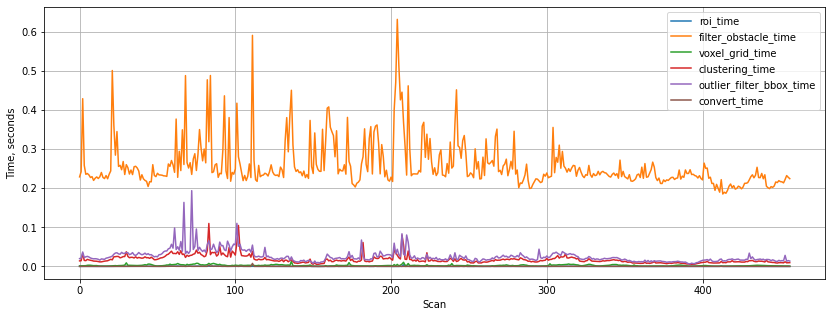

In [39]:
plt.figure(figsize=(14,5))
for i, step in enumerate(steps):
    plt.plot(steps_exec_time[i], label=step)
plt.legend(loc='best')
plt.xlabel('Scan')
plt.ylabel('Time, seconds')
plt.grid()
plt.show()

In [40]:
time_stat = list(exec_time_dct.values())
print('Min process time {} ms'.format(min(time_stat)))
print('Mean process time {} ms'.format(np.mean(time_stat)))
print('Max process time {} ms'.format(max(time_stat)))

Min process time 0.209791 ms
Mean process time 0.30462345951859954 ms
Max process time 0.709847 ms


In [41]:
ox = [int(x) for x in list(exec_time_dct.keys())]
oy = time_stat

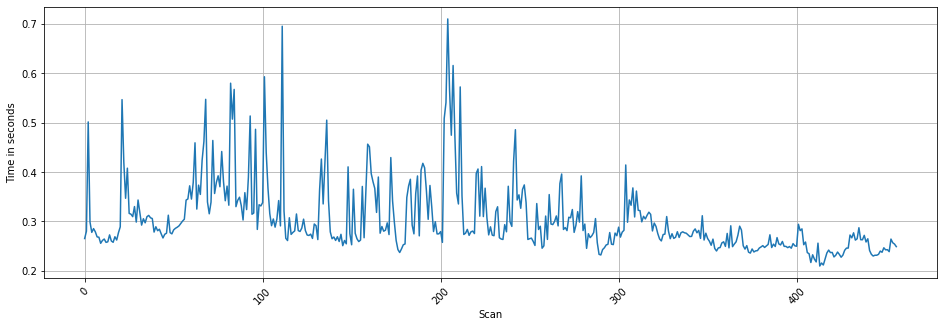

In [42]:
plt.figure(figsize=(16, 5))
plt.plot(ox, oy)
plt.xlabel('Scan')
plt.ylabel('Time in seconds')
plt.grid()
plt.xticks(rotation=45)
plt.show()

## Grep statistics of execution time

In [43]:
exec_lst = []
n_epoch = 3
for i in range(n_epoch):
    exec_time_dct = {}
    _, exec_time_dct, _ = test.get_bbox_and_stat(scan_lst[:n_scan], labels_lst[:n_scan], obstacle_lst, pipeline_optimized_pcl, write_path=None, **params_)
    exec_lst.append(exec_time_dct)

In [ ]:
exec_time_dct

In [44]:
several_exec_time_lst = [] 
for epoch in exec_lst:
    several_exec_time_lst.append([tdelta for tdelta in epoch.values()])
several_exec_time_lst = list(zip(several_exec_time_lst[0],
                                 several_exec_time_lst[1],
                                 several_exec_time_lst[2]))

In [45]:
oy_mean = [np.mean(exec_times) for exec_times in several_exec_time_lst]
oy_min = [min(exec_times) for exec_times in several_exec_time_lst]
oy_max = [max(exec_times) for exec_times in several_exec_time_lst]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


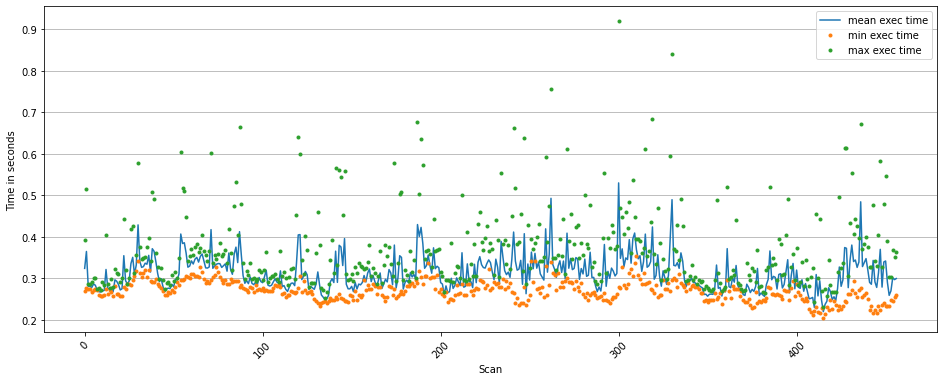

In [46]:
plt.figure(figsize=(16, 6))
plt.plot(ox, oy_mean, label='mean exec time')
plt.plot(ox, oy_min, '.', label='min exec time')
plt.plot(ox, oy_max, '.', label='max exec time')
ax = plt.axes()        
ax.yaxis.grid()
plt.xticks(rotation=45)
plt.xlabel('Scan')
plt.ylabel('Time in seconds')
plt.legend()
plt.show()